<a href="https://colab.research.google.com/github/Hackathorn/CVA-SBERT/blob/main/notebooks/CVA-SBERT-SDIclustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzes cluster similarity within Source-Definition-Item hierarchy

1. Setup analysis environment and load dataframes
1. Create working df as 3-level grouping using only Target=1
1. Compute counts/mean/var aggregations for top levels
1. Analyze those cluster similarity aggregations

# Setup Environment

## Set Notebook Parameters

In [111]:
# use gDrive if you previously saved train_data, etc.
# otherwise, use pre-generated data from repos (Default)
USE_GDRIVE = False

# save analysis plots if customized
SAVE_PLOT = False

## Import various packages


In [112]:
import pandas as pd
import numpy as np

import os.path
from os import path
from time import strftime, localtime
from google.colab import drive

## Clone CVA-SBERT GitHub or mount gDrive

In [113]:
if USE_GDRIVE:
    drive.mount('/content/drive')               # mount YOUR gDrive

    # Path to data -- change for YOUR specific Analysis folder
    path = '/content/drive/MyDrive/CVA-SBERT/Analysis-20221203-190207' ### CHANGE!!!

else:
    !git clone https://github.com/Hackathorn/CVA-SBERT  # clone repos

    # Path to data in repository
    path = '/content/CVA-SBERT/data/SetUp_Data'

path

fatal: destination path 'CVA-SBERT' already exists and is not an empty directory.


'/content/CVA-SBERT/data/SetUp_Data'

Load dataframes and create working df as simply ```df```

In [114]:
# load previous dataframes from SetUp notebook
CVA_df = pd.read_pickle(path + '/CVA_df.pkl')
token_df = pd.read_pickle(path + '/token_df.pkl')

# use only 'good' data
df = CVA_df[CVA_df.Target == 1]
# remove unneeded columns
df = df.drop(columns = ['Target', 'Definition', 'Item', 'is_train'])
# rename columns to short consist names
df.rename(columns={"Source": "S", "Def_token": "D", "Item_token": 'I'}, inplace=True)
df.rename(columns={"Cos_Sim": "Csim", "Euc_Sim": "Esim"}, inplace=True)

df

,Index,S,D,I,Csim,Esim
0,0,2978,7060,2240,0.185577,1.276263
6,6,3169,5361,5119,0.414065,1.082529
8,8,2367,9846,4760,0.253170,1.222154
13,13,12426,9358,7035,0.488197,1.011734
18,18,13903,7165,4199,0.240013,1.232872
...,...,...,...,...,...,...
28069,28069,1915,2576,2574,0.624945,0.866089
28071,28071,12822,2404,11294,0.169479,1.288814
28072,28072,3350,6839,8420,0.583409,0.912789
28074,28074,2361,6453,10551,0.383094,1.110771


# General stats on Target=1 SD Items

Find unique tokens for Sources, Definitions & Items

In [115]:
s = sorted(set(list(df['S'])))
d = sorted(set(list(df['D'])))
i = sorted(set(list(df['I'])))

print(f"Sources: unique={len(s)} head={s[:5]} tail={s[-5:]}")
print(f"Definitions: unique={len(d)} head={d[:5]} tail={d[-5:]}")
print(f"Items: unique={len(i)} head={i[:5]} tail={i[-5:]}")

Sources: unique=833 head=[317, 353, 354, 417, 875] tail=[14027, 14031, 14032, 14038, 14046]
Definitions: unique=2884 head=[0, 1, 2, 3, 4] tail=[11499, 11500, 11501, 11502, 11505]
Items: unique=8624 head=[46, 60, 66, 67, 68] tail=[11497, 11498, 11503, 11504, 11506]


Create dict of Defintion tokens for each Source
- Question... How many Defination

In [116]:
Source_to_Def = {ss: sorted(set(list(df[df.S==ss]['D']))) for ss in s}

count_Def_per_Source = [len(v) for (k, v) in Source_to_Def.items()]

print('Source + its Defs = ', {k: v for i, (k, v) in enumerate(Source_to_Def.items()) if i < 5})
print('Ratio of Defs per Source = ', sum(count_Def_per_Source)/len(count_Def_per_Source))
print('Max Defs per Source = ', max(count_Def_per_Source))

Source + its Defs =  {317: [1976, 7325], 353: [9148], 354: [130, 6809, 8466], 417: [5302, 8765], 875: [7638]}
Ratio of Defs per Source =  3.4777911164465785
Max Defs per Source =  25


Create dict of Source tokens for each Definition
- Question... Is the same Def used in more than one Source?

In [117]:
Def_to_Source = {dd: sorted(set(list(df[df.D==dd]['S']))) for dd in d}

count_Source_per_Def = [len(v) for (k, v) in Def_to_Source.items()]

print('Def + its Sources = ', {k: v for i, (k, v) in enumerate(Def_to_Source.items()) if i < 5})
print('Ratio of Sources per Def = ', sum(count_Source_per_Def)/len(count_Source_per_Def))
print('Max Sources per Def = ', max(count_Source_per_Def))
print('Defs with multiple Sources = ', [(k,v) for (k, v) in Def_to_Source.items() if len(v) > 1])

Def + its Sources =  {0: [12417], 1: [1932], 2: [1930], 3: [1926], 4: [9525]}
Ratio of Sources per Def =  1.0045076282940362
Max Sources per Def =  3
Defs with multiple Sources =  [(62, [1926, 2488]), (808, [1139, 1921, 2488]), (1670, [9531, 12452]), (2752, [1010, 3360]), (5338, [1006, 12543]), (8251, [2346, 13686]), (8644, [12641, 13679]), (9525, [1087, 1225]), (9669, [1228, 2692, 3037]), (10734, [12430, 12431]), (10793, [1123, 2586])]


RESULTS...
- Approx half of the rows (approx) for eliminating Target=0 Def-Items
- Average no of Defintions per Source is approx 3.5 with max of 25
- 9 Definitions are used by two Sources; 2 Defs are used by three Sources


#### Create function to return dict of Source-Def tuple keys with list of Item tokens

- if parms Sou & Def are not specified, assume all Sources and/or Definitions
- TODO: use pandas GroupBy for efficiency

In [118]:
def find_Item_tokens_for_SD(Sou=None, Def=None):

    # set parms Sou & Def properly
    if Sou is None: 
        Sou = sorted(set(list(df['S'])))
    elif type(Sou) != list:
        Sou = [Sou]     # if scalar, change to one-item list
        assert Sou in sorted(set(list(df['S'])))    # check if valid
    print('Sou = ', Sou)

    if Def is None: 
        Def = sorted(set(list(df['D'])))
    elif type(Def) != list:
        Def = [Def]
        assert Def in sorted(set(list(df['D'])))    # check if valid
    print('Def = ', Def)

    # x = [df[(df.S==s) & (df.D==d)]['I'] for d in Def for s in Sou]
    # x = df[(df.S==s) & (df.D==d)]['I'].items for d in Def for s in Sou

    Sou_Def_Items = []
    for s in Sou:
        for d in Def:
            x = df[(df.S==s) & (df.D==d)]['I'].tolist()
            if len(x) == 0: continue    # ignore is no Items for Sou+Def pair
            Sou_Def_Items.append([s,d,x])
            # print(s, d, len(x))

    return Sou_Def_Items


find_Item_tokens_for_SD([317, 353], [1976, 9148]) ;
# find_Item_tokens_for_SD(353, 9148)

Sou =  [317, 353]
Def =  [1976, 9148]


# Group as 2-level S-D Item hierarchy

## Group Source-Def items into clusters

In [119]:
# group Source/Definition items into cluster

SD_clus = df.groupby(['S', 'D'], as_index=False)

sim = 'Esim'    # Csim or Esim metrics
df1 =   SD_clus.agg(
        count = pd.NamedAgg(column=sim, aggfunc='size'),
        mean = pd.NamedAgg(column=sim, aggfunc='mean'),
        var = pd.NamedAgg(column=sim, aggfunc='var'),
    )
# for count=1, set var to 0
df1.loc[df1['count'] == 1, 'var'] = 0.0

print(df1.info())
df1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2897 entries, 0 to 2896
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S       2897 non-null   int64  
 1   D       2897 non-null   int64  
 2   count   2897 non-null   int64  
 3   mean    2897 non-null   float64
 4   var     2897 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 113.3 KB
None


,S,D,count,mean,var
0,317,1976,18,1.223931,0.009735
1,317,7325,18,1.158767,0.009396
2,353,9148,1,1.164086,0.000000
3,354,130,4,1.356913,0.006391
4,354,6809,20,1.276854,0.003485
...,...,...,...,...,...
2892,14032,10876,3,1.295804,0.012065
2893,14038,6622,4,0.915098,0.008272
2894,14038,8978,3,0.820599,0.012991
2895,14046,8673,2,1.176519,0.007942


## Apply HDBSCAN to SD Item clusters

In [120]:
%%capture
!pip install umap-learn hdbscan

In [121]:
from sklearn.datasets import make_blobs
import pandas as pd
import hdbscan

See [HDBSCAN API Reference](https://hdbscan.readthedocs.io/en/latest/api.html)

In [122]:
clusterer = hdbscan.HDBSCAN(
    algorithm='best', 
    alpha=1.0, 
    approx_min_span_tree=True,
    gen_min_span_tree=False, 
    leaf_size=40, 
    metric='euclidean', 
    min_cluster_size=5, 
    min_samples=None, 
    p=None
)

(numpy.ndarray, (2000, 10))

In [159]:
# Use first Source #317 with 2 Defs each with 18 Items
# df = SD_clus.get_group(317)


S317_item_tokens = df.groupby(['S'], as_index=False).get_group(317)['I'].tolist()
embeds = np.array(token_df.loc[S317_item_tokens]['encoding'].to_list())

clusterer.fit(embeds)

# HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
#     gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
#     metric='euclidean', min_cluster_size=5, min_samples=None, p=None)

HDBSCAN()

In [160]:
clusterer.labels_

array([ 0, -1,  1,  1,  0,  0,  1,  1, -1,  1,  1,  1,  1,  1,  1,  0,  0,
       -1,  1,  0, -1,  1,  1, -1, -1, -1, -1, -1,  0, -1, -1,  0,  1,  1,
       -1,  1])

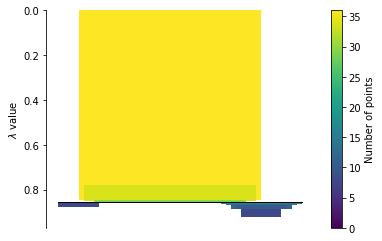

In [162]:
clusterer.condensed_tree_.plot()

In [ ]:
# SD_clus['Csim', 'Esim'].mean()
SD1 = SD_clus['Csim', 'Esim'].describe(percentiles=[])

<ipython-input-16-ed85d98e0c9d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SD1 = SD_clus['Csim', 'Esim'].describe(percentiles=[])


In [ ]:
SD1

Csim                                                    Esim            \
     count      mean       std       min       50%       max count      mean   
0     18.0  0.246400  0.115493  0.098793  0.222941  0.522491  18.0  1.223931   
1     18.0  0.324193  0.109385  0.150702  0.323953  0.572357  18.0  1.158767   
2      1.0  0.322452       NaN  0.322452  0.322452  0.322452   1.0  1.164086   
3      4.0  0.076997  0.105993 -0.014949  0.046689  0.229559   4.0  1.356913   
4     20.0  0.183167  0.075195  0.065572  0.187732  0.316475  20.0  1.276854   
...    ...       ...       ...       ...       ...       ...   ...       ...   
2892   3.0  0.156425  0.142639  0.009886  0.164572  0.294816   3.0  1.295804   
2893   4.0  0.578196  0.083418  0.475173  0.581915  0.673783   4.0  0.915098   
2894   3.0  0.658978  0.090310  0.590200  0.625485  0.761249   3.0  0.820599   
2895   2.0  0.305916  0.104846  0.231778  0.305916  0.380053   2.0  1.176519   
2896   2.0  0.510337  0.062280  0.466299  0.510337  0.554376   2.0  0.988605   

                                              
           std       min       50%       max  
0     0.098666  0.977250  1.246642  1.342540  
1     0.096931  0.924817  1.162717  1.303302  
2          NaN  1.164086  1.164086  1.164086  
3     0.079947  1.241323  1.380792  1.424745  
4     0.059032  1.169209  1.274555  1.367061  
...        ...       ...       ...       ...  
2892  0.109843  1.187589  1.292616  1.407205  
2893  0.090952  0.807734  0.914065  1.024527  
2894  0.113979  0.691015  0.865465  0.905318  
2895  0.089116  1.113505  1.176519  1.239534  
2896  0.062998  0.944059  0.988605  1.033152  

[2897 rows x 12 columns]

In [ ]:
# group Source/Definition items into cluster
SD_clus = df.groupby(['S', 'D'], as_index=False)
SD_clus['Csim', 'Esim'].mean()

<ipython-input-10-43f8cba3c843>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  SD_clus['Csim', 'Esim'].mean()


,S,D,Csim,Esim
0,317,1976,0.246400,1.223931
1,317,7325,0.324193,1.158767
2,353,9148,0.322452,1.164086
3,354,130,0.076997,1.356913
4,354,6809,0.183167,1.276854
...,...,...,...,...
2892,14032,10876,0.156425,1.295804
2893,14038,6622,0.578196,0.915098
2894,14038,8978,0.658978,0.820599
2895,14046,8673,0.305916,1.176519


In [ ]:
S_clus = df.groupby(['S'], as_index=False)
S_clus['I'].size()

,S,size
0,317,36
1,353,1
2,354,25
3,417,5
4,875,1
...,...,...
828,14027,25
829,14031,15
830,14032,13
831,14038,7


RESULTS...
- Some insights........

# Save analysis results to your gDrive - OPTIONAL

Mount gDrive and create timestamped Experiment Folder

In [ ]:
drive.mount('/content/drive')   # ignore warning if already mounted

BASE_PATH = '/content/drive/MyDrive/CVA-SBERT/'
EXP_PATH = BASE_PATH + 'Analysis-' + strftime("%Y%m%d-%H%M%S", localtime())

if path.exists(BASE_PATH) == False:
    os.mkdir(BASE_PATH)
if path.exists(EXP_PATH) == False:
    os.mkdir(EXP_PATH)

Save dataframes or other results to Experiment Folder

In [ ]:
# save initial two dataframes
CVA_df.to_pickle(EXP_PATH + '/CVA_df.pkl')
token_df.to_pickle(EXP_PATH + '/token_df.pkl')

# ...or other saving of other results, like plots
#